# Example - House sales in King County

### Introduction

The objective of this example is to develop a model for house sale prices in King County (Washington), which includes Seattle. It is the most populous county in Washington (population 1,931,249 in the 2010 census), and the 13th-most populous in the United States. The data include the homes sold between May 2014 and May 2015.

### The data set

The data set contains 13 house features plus the sale price and date, along with 21,613 observations. The variables included in the data set are:

* `id`, an identifier.

* `date`, the date when the sale took place.

* `zipcode`, the ZIP code of the house.

* `lat`, the latitude of the house.

* `long`, the longitude of the house.

* `bedrooms`, the number of bedrooms.

* `bathrooms`, the number of bathrooms.

* `sqft_above`, the square footage of the house, discountig the basement.

* `sqft_basement`, the square footage of the basement.

* `sqft_lot`, the square footage of the lot.

* `floors`, the total floors (levels) in house.

* `waterfront`, a dummy for having a view to the waterfront.

* `condition`, a 1-5 rating.

* `yr_built`, the year when the house was built.

* `yr_renovated`, the year when the house was renovated.

* `price`, the sale price.

### Importing the data

I import the data, from a **remote file**, to a **structured NumPy array**, as usual:

In [1]:
import numpy as np
path = 'https://raw.githubusercontent.com/cinnData/MLearning/main/Data/'
fname = path + 'king.csv'
data = np.genfromtxt(fname, delimiter=',', names=True, dtype=None, encoding='utf-8')

I check the shape of the array:

In [2]:
data.shape

(21613,)

The contents of the first rows:

In [3]:
data[:2]

array([(7129300520, '"20141013T000000"', 98178, 47.5112, -122.257, 3, 1.  , 1180,   0, 5650, 1., 0, 3, 1955,    0, 221900),
       (6414100192, '"20141209T000000"', 98125, 47.721 , -122.319, 3, 2.25, 2170, 400, 7242, 2., 0, 3, 1951, 1991, 538000)],
      dtype=[('id', '<i8'), ('date', '<U17'), ('zipcode', '<i8'), ('lat', '<f8'), ('long', '<f8'), ('bedrooms', '<i8'), ('bathrooms', '<f8'), ('sqft_above', '<i8'), ('sqft_basement', '<i8'), ('sqft_lot', '<i8'), ('floors', '<f8'), ('waterfront', '<i8'), ('condition', '<i8'), ('yr_built', '<i8'), ('yr_renovated', '<i8'), ('price', '<i8')])

The column `id` is useless for the purpose of this example. The date has been imported with string type, but, since we only have one year of data, I will not use it. The zipcode is currently a numeric feature, but it does not make sense as such, so it has to be taken as **categorical**. I leave it aside for the first round of the analysis.

### Target vector and feature matrix

I turn the price into thousands, to get lower figures, taking it as the **target vector**:

In [4]:
y = data['price']/1000

To build the **feature matrix**, I leave aside the first three columns and the last one:

In [5]:
X = data[list(data.dtype.names[3:-1])]

Next, I convert the `X` to an **unstructured array**: 

In [6]:
from numpy.lib.recfunctions import structured_to_unstructured
X = structured_to_unstructured(X)

Let me check that this matrix has the expected shape:

In [7]:
X.shape

(21613, 12)

### The distribution of the sale price

If these are actual sale prices and no filter for the most expensive houses has being applied, one can expect the price to have a **skewed distribution**. I check this with a **histogram**:

In [8]:
from matplotlib import pyplot as plt

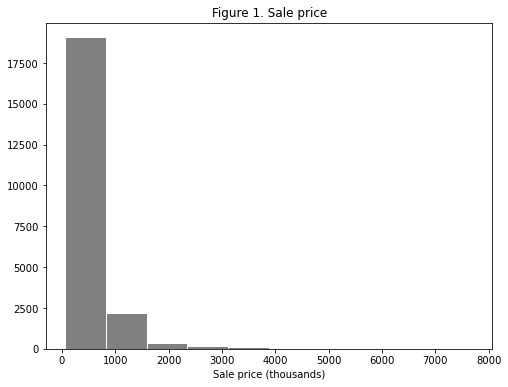

In [9]:
plt.figure(figsize=(8,6))
plt.title('Figure 1. Sale price')
plt.hist(y, color='gray', rwidth=0.97)
plt.xlabel('Sale price (thousands)');

Indeed, we find very expensive houses here, producing a **long right tail**. From our experience with linear regression, we know that this can produce a high correlation which may lead us to trust too much the predictions of this model.

### Linear regression (first round)

In a first round, I use a linear regression model to predict the sale price of the houses from the current features. To do this I call the class `LinearRegression`, from the scikit-learn subpackage `linear_model`.

In [10]:
from sklearn.linear_model import LinearRegression

I instantiate an estimator of this class, applying the methods `fit` and `score`, as I have done in previous examples:

In [11]:
linreg1 = LinearRegression()
linreg1.fit(X, y)
round(linreg1.score(X, y), 3)

0.646

I got a correlation about 0.8, which is a respectable value, since sale prices are not easy to predict. The predicted prices are obtained as:

In [12]:
ypred1 = linreg1.predict(X)

As a cautionary step, I plot the actual price versus the predicted price:

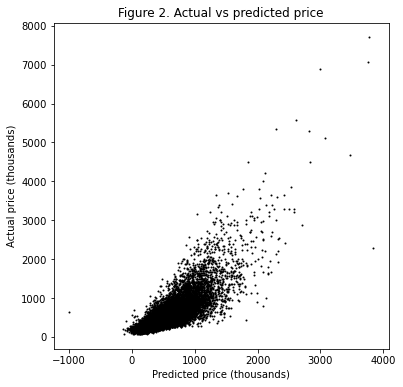

In [13]:
plt.figure(figsize=(6,6))
plt.scatter(x=ypred1, y=y, color='black', s=1)
plt.title('Figure 2. Actual vs predicted price')
plt.xlabel('Predicted price (thousands)')
plt.ylabel('Actual price (thousands)');

Well, in spite of the correlation found (which I don't trust completely), some of the predicted prices don't make sense. Some of the houses get a negative price (one house is priced at minus one million!). The number of negative predictions can be calculated with:

In [14]:
np.sum(ypred1 < 0)

38

### Incorporating the zipcode

Discarding the zipcode, I may missing relevant information, since it is known that the location of a house has a strong influence on its price. I have included the longitude and latitude, but probably the zipcodes will bring in more predictive power. So in a second round, I leave aside longitude and latitude (you can keep them if you prefer, but they will not contribute once the zipcode is included), replacing them by the zipcode.

Of course, entering the zipcode as a number in a linear equation is not going to be productive, so I turn it into a **set of dummies**. First, I collect the numeric features (without longitude and latitude) in a new matrix: 

In [15]:
X1 = data[list(data.dtype.names[5:-1])]
X1 = structured_to_unstructured(X1)

To create the dummies, I use a `OneHotEncoder` transformer. First, I import the **transformer class** from the scikit-learn subpackage `preprocessing`:

In [16]:
from sklearn.preprocessing import OneHotEncoder

Next, I instantiate a transformer as usual in scikit-learn:

In [17]:
enc = OneHotEncoder()

Then, I fit the transformer `enc` to the zipcode. Since `fit` takes only 2d arrays, I have to reshape `data['zipcode']`, which is a 1d array, into a 2d array.

In [18]:
enc.fit(data['zipcode'].reshape(21613,1))

OneHotEncoder()

I get the encoded matrix as:

In [19]:
X2 = enc.transform(data['zipcode'].reshape(21613,1)).toarray()

Now, `X2` is 2d array made of dummies:

In [20]:
X2.shape

(21613, 70)

Let me check that this matrix contains as many ones as houses I have in the data, and the rest are zeros:

In [21]:
np.unique(X2, return_counts=True)

(array([0., 1.]), array([1491297,   21613]))

Finally, I put the two feature matrices together with the NumPy function `concatenate`. Note that `axis=1` indicates the two matrices are concatenated horizontally. 

In [22]:
X = np.concatenate([X1, X2], axis=1)

Let me check the shape of the final feature matrix: 

In [23]:
X.shape

(21613, 80)

### Linear regression (second round)

In a second round, I fit a linear equation to the new feature matrix:

In [24]:
linreg2 = LinearRegression()
linreg2.fit(X, y)
round(linreg2.score(X, y), 3)

0.785

The improvement in the correlation is quite clear. Let us examine the predicted prices:

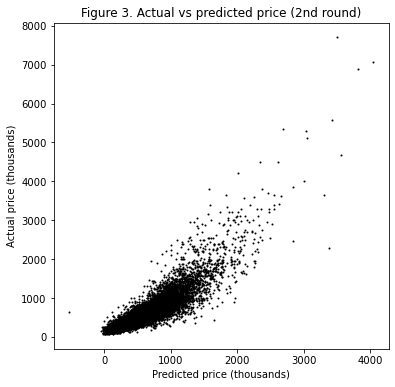

In [25]:
ypred2 = linreg2.predict(X)
plt.figure(figsize=(6,6))
plt.scatter(x=ypred2, y=y, color='black', s=1)
plt.title('Figure 3. Actual vs predicted price (2nd round)')
plt.xlabel('Predicted price (thousands)')
plt.ylabel('Actual price (thousands)');

So, we have improved our predictive model, though we still have negative predictions:

In [26]:
np.sum(ypred2 < 0)

16

### Homework

1. The distribution of the price is quite **skewed**, which is a fact of life in real state. So, the extreme values in the right tail of the distribution can exert an undesired influence on the coefficients of the regression equation. Transformations, such as the square root or the logarithm, are recommended in Statistics textbooks in many situations. In particular, the **log transformation** is recommended for variables with skewed distributions, to limit the influence of extreme values. Develop a model for predicting the price which is based on a linear regression equation which has the logarithm of the price on the left side. Do you get better predictions with this model? 

2. Evaluate both models expressing the prediction errors in percentage term. Which is better?

3. Trim the data set, dropping the houses beyond a certain threshold of price and/or size. Do you get better models?